<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 3
Авторы материала: Юрий Кашницкий (@yorko) и Максим Уваров (@maxis42). Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 3 
## <center> Деревья решений для классификации и регрессии

**В этом задании мы разберемся с тем, как работает дерево решений в задаче регрессии, а также построим (и настроим) классифицирующие деревья решений в задаче прогнозирования сердечно-сосудистых заболеваний. 
Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://docs.google.com/forms/d/1bXgaJRh4naJOGzE_Li2k50TN0kOPJdNhMtHl6H4t3Lk/edit).**

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from IPython.display import Image

## 1. Простой пример восстановления регрессии с помощью дерева решений

Рассмотрим следующую одномерную задачу восстановления регрессии. Неформально, надо построить функцию $a(x)$, приближающую искомую зависимость $y = f(x)$ в терминах среднеквадратичной ошибки: $min \sum_i {(a(x_i) - f(x_i))}^2$. Подробно мы рассмотрим эту задачу в следующий раз ([4-я статья курса](https://habrahabr.ru/company/ods/blog/323890/)), а пока поговорим о том, как решать эту задачу с помощью дерева решений. Предварительно прочитайте небольшой раздел ["Дерево решений в задаче регрессии"](https://habrahabr.ru/company/ods/blog/322534/#derevo-resheniy-v-zadache-regressii) 3-ей статьи курса. 

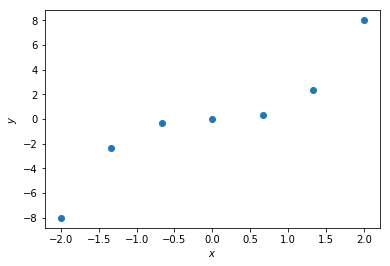

In [24]:
X = np.linspace(-2, 2, 7)
y = X ** 3
#print(y.mean())
#y2 = np.linspace(y.mean(), y.mean(), 7)

plt.scatter(X, y)
#plt.plot(X, y2)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

Проделаем несколько шагов в построении дерева решений. Исходя из соображений симметрии, выберем пороги для разбиения равными соответственно 0, 1.5 и -1.5. Напомним, что в случае задачи восстановления регрессии листовая вершина выдает среднее значение ответа по всем объектам обучающей выборки, попавшим в эту вершину.

Итак, начнём. Дерево глубины 0 состоит из одного корня, который содержит всю обучающую выборку. Как будут выглядеть предсказания данного дерева для $x \in [-2, 2]$? Постройте соответствующий график. Тут без `sklearn` – разбираемся просто с ручкой, бумажкой и Python, если надо.

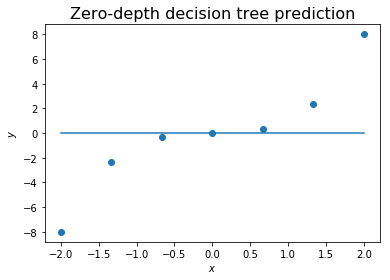

In [28]:
# Ваш код здесь
X = np.linspace(-2, 2, 7)
y = X ** 3
#print(y.mean())
y2 = np.linspace(y.mean(), y.mean(), 7)

plt.scatter(X, y)
plt.plot(X, y2)
plt.title("Zero-depth decision tree prediction", fontsize = 16)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

Произведем первое разбиение выборки по предикату $[x < 0]$. Получим дерево глубины 1 с двумя листьями. Постройте аналогичный график предсказаний для этого дерева.

-3.5555555555555554


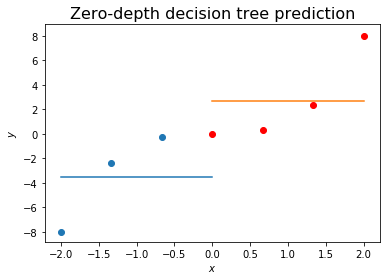

In [44]:
#X = np.linspace(-2, 2, 7)
X1 = np.linspace(-2, 0, 4)
X2 = np.linspace(0, 2, 4)
y1 = X1 ** 3
y2 = X2 ** 3
print(y1[:3].mean())
y1_mean = np.linspace(y1[:3].mean(), y1[:3].mean(), 4)
y2_mean = np.linspace(y2.mean(), y2.mean(), 4)

plt.scatter(X1[:3], y1[:3])
plt.scatter(X2, y2, color = 'r')
plt.plot(X1, y1_mean)
plt.plot(X2, y2_mean)
plt.title("Zero-depth decision tree prediction", fontsize = 16)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

В алгоритме построения дерева решений признак и значение порога, по которым происходит разбиение выборки, выбираются исходя из некоторого критерия. Для регрессии обычно используется дисперсионный критерий:
$$Q(X, j, t) = D(X) - \dfrac{|X_l|}{|X|} D(X_l) - \dfrac{|X_r|}{|X|} D(X_r),$$
где $X$ – выборка, находящаяся в текущей вершине, $X_l$ и $X_r$ – разбиение выборки $X$ на две части по предикату $[x_j < t]$ (то есть по $j$-ому признаку и порогу $t$), $|X|$, $|X_l|$, $|X_r|$ - размеры соответствующих выборок, а $D(X)$ – дисперсия ответов на выборке $X$:
$$D(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j – \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2,$$
где $y_i = y(x_i)$ – ответ на объекте $x_i$. При каждом разбиении вершины выбираются признак $j$ и значение порога $t$, максимизирующие значение функционала $Q(X, j, t)$.

В нашем случае признак всего один, поэтому $Q$ зависит только от значения порога $t$ (и ответов выборки в данной вершине). 

Постройте график функции $Q(X, t)$ в корне в зависимости от значения порога $t$ на отрезке $[-1.9, 1.9]$.

In [8]:
def regression_var_criterion(X, y, t):
    #посчитать D(X)
    ret = np.var(y)
    #разбить выборку на Xl и Xr
    Xl = []
    Xr = []
    for j in range(len(X)):
        if (X[j]<t): 
        # дейвтсвия для Xl
            Xl.append(y[j])
        else:
        #действия для Xr
            Xr.append(y[j])
    Xl = np.array(Xl)
    Xr = np.array(Xr)
    ret = ret - len(Xl)*np.var(Xl)/len(X) - len(Xr)*np.var(Xr)/len(X)
    return ret



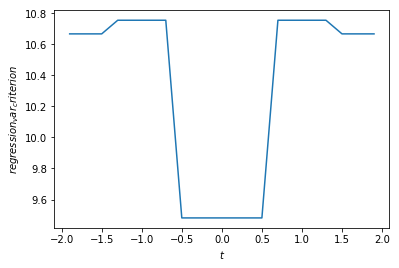

In [12]:
X = np.linspace(-2, 2, 7)
y = X ** 3
#print(y.mean())
#y2 = np.linspace(y.mean(), y.mean(), 7)

t_array = np.linspace(-1.9, 1.9, 20)
y_t = []
for t in t_array:
    y_t.append(regression_var_criterion(X, y, t))
    #print (regression_var_criterion(X, y, t))
    
y_t = np.array(y_t)

plt.plot(t_array, y_t)
#plt.plot(X, y2)
plt.xlabel(r'$t$')
plt.ylabel(r'$regression_var_criterion$');

In [46]:
# Ваш код здесь
#подозреваю, что нет

**<font color='red'>Вопрос 1.</font> Оптимально ли с точки зрения дисперсионного критерия выбранное нами значение порога $t = 0$?**
- Да
- Нет

Теперь произведем разбиение в каждой из листовых вершин. В левой (соответствующей ветви $x < 0$) – по предикату $[x < -1.5]$, а в правой (соответствующей ветви $x \geqslant 0$) – по предикату $[x < 1.5]$. Получится дерево глубины 2 с 7 вершинами и 4 листьями. Постройте график предсказаний этого дерева для $x \in [-2, 2]$.

-8.0


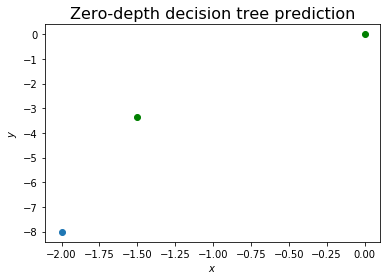

In [55]:
# Ваш код здесь
X11 = np.linspace(-2, -1.5, 2)
X12 = np.linspace(-1.5, 0, 2)
X21 = np.linspace(0, 1.5, 2)
X22 = np.linspace(1.5, 2, 2)
y11 = X11 ** 3
y12 = X12 ** 3
y21 = X21 ** 3
y22 = X22 ** 3
print(y11[:1].mean())
y11_mean = np.linspace(y11[:1].mean(), y11[:1].mean(), 1)
#y2_mean = np.linspace(y2.mean(), y2.mean(), 4)

plt.scatter(X11[0], y11[0])
plt.plot(X11[:1], y11_mean)
plt.scatter(X12, y12, color = 'g')
#plt.scatter(X1[:3], y1[:3])
#plt.scatter(X2, y2, color = 'r')
#plt.plot(X1, y1_mean)
#plt.plot(X2, y2_mean)
plt.title("Zero-depth decision tree prediction", fontsize = 16)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

**<font color='red'>Вопрос 2.</font> Из какого числа отрезков состоит график (необходимо считать как горизонтальные, так и вертикальные прямые), изображающий предсказания построенного дерева на отрезке [-2, 2]?**
- 5
- 6
- 7
- 8

In [ ]:
#answ 7, #3

## 2. Построение дерева решений для прогноза сердечно-сосудистых заболеваний
Считаем в `DataFrame` знакомый нам набор данных по сердечно-сосудистым заболеваниям. 

In [14]:
df = pd.read_csv('../../data/mlbootcamp5_train.csv', 
                 index_col='id', sep=';')

In [15]:
my_df = df
my_df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Сделайте небольшие преобразования признаков: постройте признак "возраст в годах" (полных лет), а также постройте по 3 бинарных признака на основе `cholesterol` и `gluc`, где они, соответственно, равны 1, 2 или 3. Эта техника называется dummy-кодированием или One Hot Encoding (OHE), удобней всего в данном случае использовать `pandas.get_dummmies`. Исходные признаки `cholesterol` и `gluc` после кодирования использовать не нужно.

In [16]:
# Ваш код здесь
my_df['age_years'] = (my_df['age'] // 365.25).astype(int)
my_df = pd.concat([my_df, pd.get_dummies(my_df['cholesterol'], prefix="cholesterol"),
                    pd.get_dummies(my_df['gluc'], prefix="gluc")],
                    axis=1)
y = my_df['cardio']
my_df.drop(['cholesterol', 'gluc','cardio'], axis=1, inplace=True)
my_df.tail()

,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,age_years,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3
id,,,,,,,,,,,,,,,,
99993,19240,2,168,76.0,120,80,1,0,1,52,1,0,0,1,0,0
99995,22601,1,158,126.0,140,90,0,0,1,61,0,1,0,0,1,0
99996,19066,2,183,105.0,180,90,0,1,0,52,0,0,1,1,0,0
99998,22431,1,163,72.0,135,80,0,0,0,61,1,0,0,0,1,0
99999,20540,1,170,72.0,120,80,0,0,1,56,0,1,0,1,0,0


Разбейте выборку на обучающую и отложенную (holdout) части в пропорции 7/3. Для этого используйте метод `sklearn.model_selection.train_test_split`, зафиксируйте у него `random_state`=17.

In [17]:
X_train, X_valid, y_train, y_valid = train_test_split(my_df.values, y, test_size=0.3,
                                                          random_state=17)

Обучите на выборке `(X_train, y_train)` дерево решений с ограничением на максимальную глубину в 3. Зафиксируйте у дерева `random_state=17`. Визуализируйте дерево с помошью `sklearn.tree.export_graphviz`, `dot` и `pydot`. Пример дан в [статье](https://habrahabr.ru/company/ods/blog/322534/) под спойлером "Код для отрисовки дерева". Названия файлов писать без кавычек, для того чтобы работало в jupyter notebook. Обратите внимание, что команды в Jupyter notebook, начинающиеся с восклицательного знака – это терминальные команды (которые мы обычно запускаем в терминале/командной строке).

In [18]:
# Ваш код здесь
clf_tree = DecisionTreeClassifier(max_depth=3, random_state=17)

# обучаем дерево
clf_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')

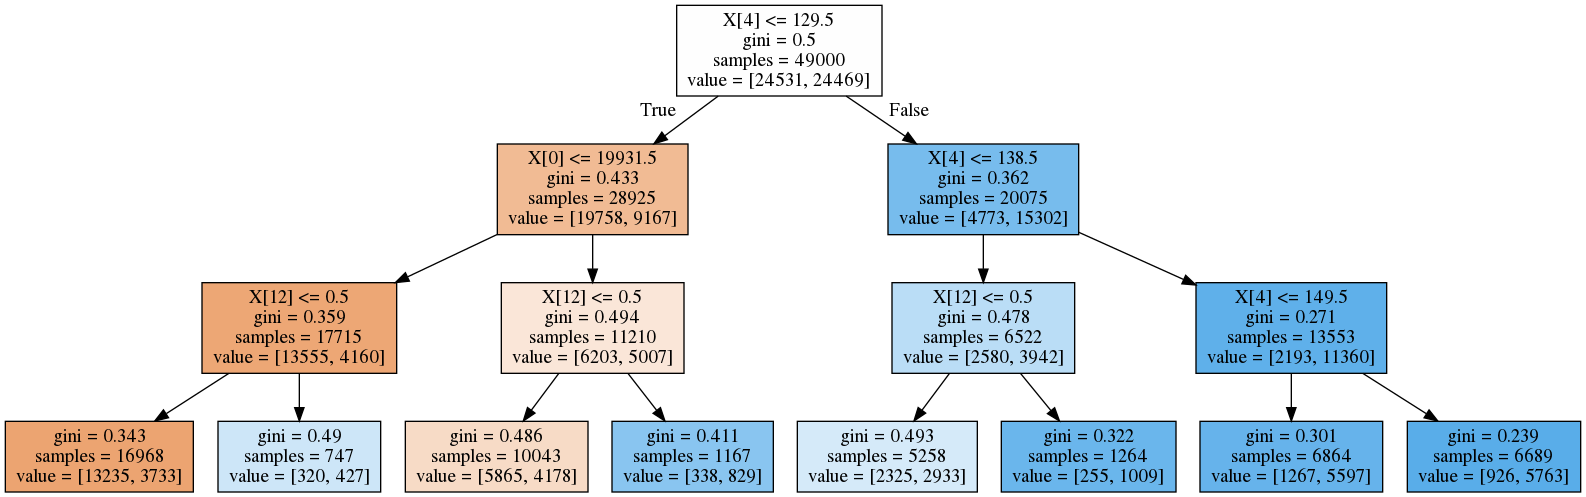

In [19]:
export_graphviz(clf_tree,  
                out_file='../../img/ssz_33.dot', filled=True)
#feature_names=['x1', 'x2'],
!dot -Tpng ../../img/ssz_33.dot -o ../../img/ssz_33.png
!rm ../../img/ssz_33.dot
Image("../../img/ssz_33.png")

In [20]:
labels = my_df.columns
print(labels[0])
print(labels[4])
print(labels[12])
print('---')
print(labels[1])
print(labels[5])
print(labels[13])
#answ #4

age
ap_hi
cholesterol_3
---
gender
ap_lo
gluc_1


**<font color='red'>Вопрос 3.</font> Какие 3 признака задействуются при прогнозе в построенном дереве решений? (то есть эти три признака "можно найти в дереве")**
- weight, height, gluc=3
- smoke, age, gluc=3
- age, weight, chol=3
- age, ap_hi, chol=3

Сделайте с помощью обученного дерева прогноз для отложенной выборки `(X_valid, y_valid)`. Посчитайте долю верных ответов (accuracy).

In [10]:
tree_pred = clf_tree.predict(X_valid)
acc1 = accuracy_score(y_valid, tree_pred)
print(acc1)

0.7212857142857143


Теперь на кросс-валидации по выборке  `(X_train, y_train)`  настройте глубину дерева, чтобы повысить качество модели. Используйте GridSearchCV, 5-кратную кросс-валидацию. Зафиксируйте у дерева `random_state`=17. Перебирайте параметр `max_depth` от 2 до 10. 

In [11]:
tree_params = {'max_depth': list(range(2, 11))}

#tree_grid = GridSearchCV # Ваш код здесь

#tree_clf = DecisionTreeClassifier(max_depth=5, random_state=17)

tree_grid =  GridSearchCV (clf_tree, tree_params, cv=5, n_jobs=-1, verbose=True, return_train_score=True)

tree_grid.fit(X_train, y_train)

print(tree_grid.best_params_)

print(tree_grid.best_score_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   12.2s finished


{'max_depth': 6}
0.7319591836734693


In [7]:
#tree_grid.cv_results_

Нарисуйте график того, как меняется средняя доля верных ответов на кросс-валидации в зависимости от значения `max_depth`.

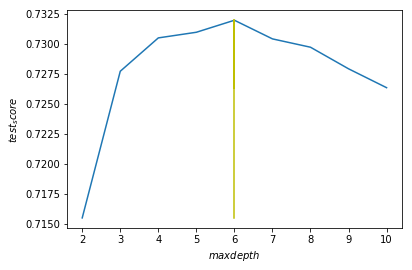

In [12]:
df_test_score = tree_grid.cv_results_['mean_test_score']
df_max_depth = list(range(2,11))

X6 = np.linspace(6,6,9)
plt.plot(df_max_depth, df_test_score)
plt.plot(X6, df_test_score, color='y')
plt.ylabel(r'$test_score$')
plt.xlabel(r'$max depth$');

Выведите лучшее значение `max_depth`, то есть такое, при котором среднее значение метрики качества на кросс-валидации максимально. Посчитайте также, какова теперь доля верных ответов на отложенной выборке. Все это можно сделать с помощью обученного экземпляра класса `GridSearchCV`.

In [13]:
# Ваш код здесь
pred_grid1 = tree_grid.predict(X_valid)
#tree_pred = clf_tree.predict(X_valid) - #было 0.7212
acc2 = accuracy_score(y_valid, pred_grid1) # стало 0.7258
print(acc1)
improve = (acc2 - acc1) / acc1 * 100
print(improve)     #нет
#Итого - да, нет, ответ #2

0.7212857142857143
0.6271869016967002


**<font color='red'>Вопрос 4.</font> Имеется ли на кривой валидации по максимальной глубине дерева пик `accuracy`, если перебирать `max_depth` от 2 до 10? Повысила ли настройка глубины дерева качество классификации (accuracy) более чем на 1% на отложенной выборке (надо посмотреть на выражение (acc2 - acc1) / acc1 * 100%, где acc1 и acc2 – доли верных ответов на отложенной выборке до и после настройки max_depth соответственно)?**
- да, да
- да, нет
- нет, да
- нет, нет

Обратимся опять (как и в 1 домашке) к картинке, демонстрирующей шкалу SCORE для расчёта риска смерти от сердечно-сосудистого заболевания в ближайшие 10 лет.
<img src='../../img/SCORE2007.png' width=70%>

Создайте бинарные признаки, примерно соответствующие этой картинке:
- $age \in [45,50), \ldots age \in [60,65) $ (4 признака)
- верхнее артериальное давление: $ap\_hi \in [120,140), ap\_hi \in [140,160), ap\_hi \in [160,180),$ (3 признака)

Если значение возраста или артериального давления не попадает ни в один из интервалов, то все бинарные признаки будут равны нулю. Далее будем строить дерево решений с этим признаками, а также с признаками ``smoke``, ``cholesterol``  и ``gender``. Из признака ``cholesterol`` надо сделать 3 бинарных, соотв-х уникальным значениям признака ( ``cholesterol``=1,  ``cholesterol``=2 и  ``cholesterol``=3), эта техника называется dummy-кодированием или One Hot Encoding (OHE). Признак ``gender`` надо перекодировать: значения 1 и 2 отобразить на 0 и 1. Признак лучше переименовать в ``male`` (0 – женщина, 1 – мужчина). В общем случае кодирование значений делает ``sklearn.preprocessing.LabelEncoder``, но в данном случае легко обойтись и без него.

Итак, дерево решений строится на 12 бинарных признаках (исходные признаки не берем).

Постройте дерево решений с ограничением на максимальную глубину = 3 и обучите его на всей исходной обучающей выборке. Используйте `DecisionTreeClassifier`, на всякий случай зафикисровав `random_state=17`, остальные аргументы (помимо `max_depth` и `random_state`) оставьте по умолчанию. 

**<font color='red'>Вопрос 5.</font> Какой бинарный признак из 12 перечисленных оказался самым важным для обнаружения ССЗ, то есть поместился в вершину построенного дерева решений?**
- Верхнее артериальное давление от 160 до 180 (мм рт.ст.)
- Пол мужской / женский
- Верхнее артериальное давление от 140 до 160 (мм рт.ст.)
- Возраст от 50 до 55 (лет)
- Курит / не курит
- Возраст от 60 до 65 (лет)

In [21]:
bin_df = my_df
#bin_df.head()
bin_df['age_years_1'] = my_df['age_years'].map(lambda x: 1 if x >= 45 and x < 50 else 0)
bin_df['age_years_2'] = my_df['age_years'].map(lambda x: 1 if x >= 50 and x < 55 else 0)
bin_df['age_years_3'] = my_df['age_years'].map(lambda x: 1 if x >= 55 and x < 60 else 0)
bin_df['age_years_4'] = my_df['age_years'].map(lambda x: 1 if x >= 60 and x < 65 else 0)
#ap_hi∈[120,140),ap_hi∈[140,160),ap_hi∈[160,180)

In [22]:
bin_df['ap_hi_1'] = my_df['ap_hi'].map(lambda x: 1 if x >=120 and x < 140 else 0)
bin_df['ap_hi_2'] = my_df['ap_hi'].map(lambda x: 1 if x >=140 and x < 160 else 0)
bin_df['ap_hi_3'] = my_df['ap_hi'].map(lambda x: 1 if x >=160 and x < 180 else 0)

In [23]:
bin_df['male'] = my_df['gender'].map(lambda x: 1 if x==2 else 0)
bin_df.iloc[1000:1005]

,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,age_years,...,gluc_2,gluc_3,age_years_1,age_years_2,age_years_3,age_years_4,ap_hi_1,ap_hi_2,ap_hi_3,male
id,,,,,,,,,,,,,,,,,,,,,
1389,21043,2,168,82.0,160,1000,0,0,0,57,...,0,0,0,0,1,0,0,0,1,1
1390,23505,1,170,80.0,160,100,0,0,1,64,...,0,0,0,0,0,1,0,0,1,0
1391,16174,1,160,58.0,110,80,0,0,1,44,...,0,0,0,0,0,0,0,0,0,0
1393,20515,1,176,65.0,140,80,0,0,1,56,...,0,0,0,0,1,0,0,1,0,0
1395,17554,1,156,50.0,120,80,0,0,1,48,...,0,1,1,0,0,0,1,0,0,0


In [24]:
bin_df.drop(['age', 'gender','height', 'weight', 'ap_hi', 'ap_lo', 'age_years'], axis=1, inplace=True)

In [25]:
bin_df.iloc[1000:1005]
bin_df.columns

Index(['smoke', 'alco', 'active', 'cholesterol_1', 'cholesterol_2',
       'cholesterol_3', 'gluc_1', 'gluc_2', 'gluc_3', 'age_years_1',
       'age_years_2', 'age_years_3', 'age_years_4', 'ap_hi_1', 'ap_hi_2',
       'ap_hi_3', 'male'],
      dtype='object')

In [26]:
bin_df.drop(['alco', 'active', 'gluc_1', 'gluc_2', 'gluc_3'], axis=1, inplace=True)

In [27]:
print(bin_df.columns)
print(bin_df.shape)

Index(['smoke', 'cholesterol_1', 'cholesterol_2', 'cholesterol_3',
       'age_years_1', 'age_years_2', 'age_years_3', 'age_years_4', 'ap_hi_1',
       'ap_hi_2', 'ap_hi_3', 'male'],
      dtype='object')
(70000, 12)


In [28]:
# Ваш код здесь
ssz_tree = DecisionTreeClassifier(max_depth=3, random_state=17)

# обучаем дерево
ssz_tree.fit(bin_df, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')

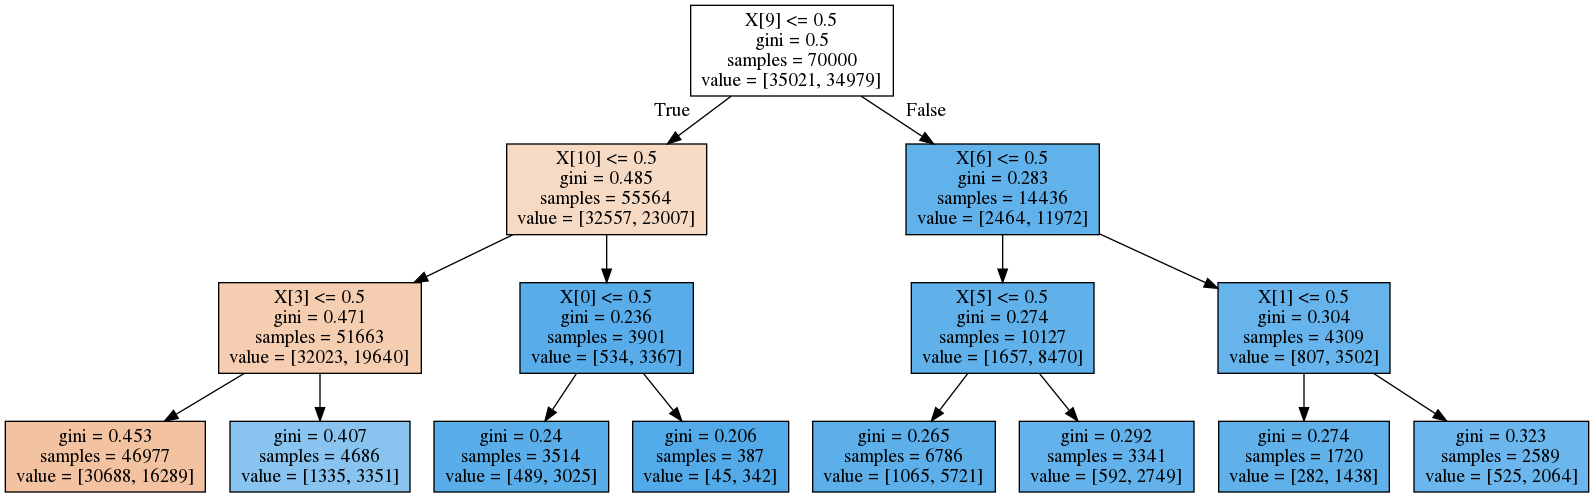

In [29]:
export_graphviz(ssz_tree,  
                out_file='../../img/ssz_bin_33.dot', filled=True)
#feature_names=['x1', 'x2'],
!dot -Tpng ../../img/ssz_bin_33.dot -o ../../img/ssz_bin_33.png
!rm ../../img/ssz_bin_33.dot
Image("../../img/ssz_bin_33.png")

In [30]:
bin_df.columns[9]

'ap_hi_2'

In [31]:
#ответ Верхнее артериальное давление от 140 до 160 (мм рт.ст.) - #3